# Project 1
## Team members:
### Nguyen N
### Brandon H
### Jennifer M
### Sam Y

In [1]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.extmath import randomized_svd


from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline


from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC # for problem 3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

import nltk
from nltk import pos_tag

nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


import itertools


import pandas as pd

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

import time

# MinMaxScaler for negative values for LSI
from sklearn.preprocessing import MinMaxScaler


[nltk_data] Downloading package punkt to /Users/nnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nnguyen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/nnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Helper Methods

In [2]:
# I make histogram
def plot_histogram(dataset_target, dataset_target_names):
    number_of_documents = []

    for i in range(len(dataset_target_names)):
        number_of_documents.append(len([x for x in dataset_target if x == i]))

    #plot histogram
    x_labels = dataset_target_names
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.35 for i in range(1,9)])
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize = 12)

    rects = plt.bar([i for i in range(1,9)], number_of_documents, align='edge')
    plt.xlabel('Topics', fontsize = 14)
    plt.ylabel('Number of Documents', fontsize = 14)
    plt.title('Number of documents per topic ', fontsize = 18)
    plt.axis([0.5,9,0,1100])

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%d' % int(height), ha='center', va='bottom')
    print('Length: ' + str(len(dataset_target)))
    plt.show()

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
       
# I morph stuff.
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

# I lematize stuff.
def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(not is_number(word)):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize


# Oh look, I can make confusion matrix
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['Computer\n Technology', 'Recreational\n Activity']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Just using this for logistic regression part, maybe will be useful for other parts too (not using pipes)
def roc_plotter(model, data, labels):
    scores = model.decision_function(data)
    fpr, tpr, thresholds = metrics.roc_curve(labels,scores,pos_label=1)
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
# def predict_and_plot_svc(train_set, test_set, binary_train_target, binary_test_target, gamma):
#     svc = svm.SVC(gamma = gamma, probability=True)
#     svc.fit(train_set, binary_train_target)
#     svc_predicted = svc.predict(test_set)

#     print('gamma: '+ str(gamma))
#     print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
#     print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
#     print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
#     print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))
    
#     #compute confusion matrix
#     cnf_matrix = metrics.confusion_matrix(binary_test_target, svc_predicted)
#     np.set_printoptions(precision=2)

#     # Plot confusion matrix
#     plt.figure()
#     plot_confusion_matrix(cnf_matrix,
#                       title='Confusion matrix, without normalization')
#     plt.show()
    
#     # ROC curve
#     print('ROC curve')
#     roc_plotter(svc,test_set,binary_test_target) 

def calculate_fpr_tpr(prob_func, labels):
#     scores = model.decision_function(data)
    fpr, tpr, thresholds = metrics.roc_curve(labels,prob_func,pos_label=1)
    return fpr, tpr

def combined_roc_plotter(fprs, tprs, gammas, meths):
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve', fontsize=23)
    for i in range(len(fprs)):
        plt.plot(fprs[i],tprs[i], label = 'ROC Curve: {meth} {gamma}'.format(meth=meths[i], gamma=gammas[i]) )
    plt.legend(loc="lower right")
    plt.show()
    
def predict_calculate_svc(train_set, test_set, binary_train_target, binary_test_target, gamma='auto', C=1.0):
    plt.gcf().clear()
    svc = svm.SVC(C = C, probability=True, kernel='linear')
    svc.fit(train_set, binary_train_target)
    svc_predicted = svc.predict(test_set)

    print('gamma: '+ str(gamma))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))
    
    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, svc_predicted)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(svc.decision_function(test_set), binary_test_target)
    return fpr, tpr
    
def predict_calculate_naive_bayes(train_set, test_set, binary_train_target, binary_test_target):
    plt.gcf().clear()
    gnb = GaussianNB()
    gnb.fit(train_set, binary_train_target)
    pred = gnb.predict(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), pred)))
    
    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(gnb.predict_proba(test_set)[:,1], binary_test_target)
    return fpr, tpr


def predict_calculate_logistics(train_set, test_set, binary_train_target, binary_test_target, c_value, penalty='l2'):
    plt.gcf().clear()
    log = LogisticRegression(C=c_value, penalty=penalty)
    log.fit(train_set, binary_train_target)
    pred = log.predict(test_set)

    print('C value: ' + str(c_value))
    print('Penalty: ' + str(penalty))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), pred)))   
    print("Coefficient Statistics: ")
    print("mean = %f, std = %f" % (np.mean(log.coef_), np.std(log.coef_)))

    #compute confusion matrix
    cnf_matrix = metrics.confusion_matrix(binary_test_target, pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    plt.show() 
    
    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(log.decision_function(test_set), binary_test_target)
    return fpr, tpr


### QUESTION 1: To get started, plot a histogram of the number of training documents per category to check if they are evenly distributed.

In [3]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [4]:
train_dataset = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

test_dataset = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

# Load in training and test sets with/without footers (re-defining to prevent screwing up existing code)

# Remove headers and footers
train_dataset_rmv_headfoot = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))
test_dataset_rmv_headfoot = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers', 'footers'))

# Keep headers and footers
train_dataset_keep_headfoot = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42)
test_dataset_keep_headfoot = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42)

# comp_tech_train = fetch_20newsgroups(subset='train', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# rec_act_train = fetch_20newsgroups(subset='train', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# comp_tech_test = fetch_20newsgroups(subset='test', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))
# rec_act_test = fetch_20newsgroups(subset='test', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers'))


# train_target_names = data_dict['Computer Technology Train']['target_names'] + data_dict['Recreational Activity Train']['target_names']

# test_target = data_dict['Computer Technology Test']['target'] + data_dict['Recreational Activity Test']['target']
# test_target_names = data_dict['Computer Technology Test']['target_names'] + data_dict['Recreational Activity Test']['target_names']



# Turn Multiclass into Binary

In [5]:
binary_train_target = train_dataset.target.copy()
binary_test_target = test_dataset.target.copy()
computer_class_indices = [0,1,2,3]
recreational_class_indices = [4,5,6,7]

computer_class_label = 0
recreational_class_label = 1

# Binarize computer-class labels
for i in computer_class_indices:
    binary_train_target[binary_train_target == i] = computer_class_label
    binary_test_target[binary_test_target == i] = computer_class_label

# Binarize recreational-class labels
for i in recreational_class_indices:
    binary_train_target[binary_train_target==i] = recreational_class_label
    binary_test_target[binary_test_target == i] = recreational_class_label
 
print("Sanity Check!\n")
print("Training Set")
print("Original train_dataset.target: " + str(train_dataset.target[0:20]))
print("Binarized train_dataset.target:" + str(binary_train_target[0:20]))
print("\nTest Set")
print("Original test_dataset.target:  " + str(test_dataset.target[0:20]))
print("Binarized test_dataset.target: " + str(binary_test_target[0:20]))

Sanity Check!

Training Set
Original train_dataset.target: [6 7 4 2 1 3 0 7 5 3 0 5 5 5 3 1 3 0 0 2]
Binarized train_dataset.target:[1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]

Test Set
Original test_dataset.target:  [3 2 3 3 2 3 2 6 0 1 0 1 7 7 1 5 7 2 0 1]
Binarized test_dataset.target: [0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0]


Train Dataset
Length: 4732


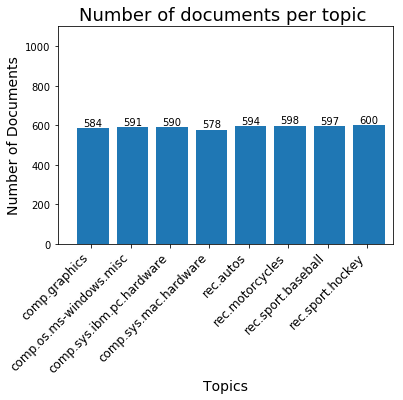

Test Dataset
Length: 3150


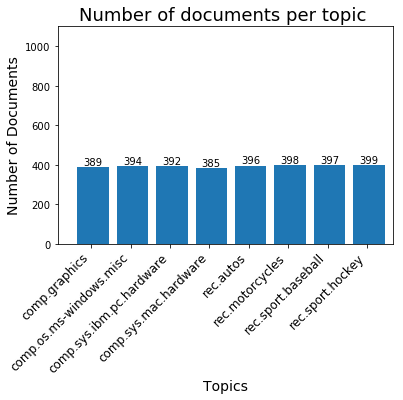

In [6]:
print('Train Dataset')
plot_histogram(train_dataset.target, train_dataset.target_names)

print('Test Dataset')
plot_histogram(test_dataset.target, test_dataset.target_names)

# Binary Classification

## Feature Extraction

In [7]:
### QUESTION 2: Use the following specs to extract features from the textual data:
### • Use the default stopwords of the CountVectorizer
### • Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
### • Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
### • Use min_df=3
### Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [15]:
# set lemmatize 
import time

t1 = time.time()
print("Lemmatizing training set with removed headers/footers...")
train_dataset_lemmatized_rmv_headfoot = []
for item in train_dataset_rmv_headfoot.data:
    train_dataset_lemmatized_rmv_headfoot.append(' '.join(lemmatize_parse(item)))
print("Completed training set with removed head/foot in %f sec\n" %(time.time()-t1))

t1 = time.time()
print("Lemmatizing test set with removed headers/footers...")
test_dataset_lemmatized_rmv_headfoot = []
for item in test_dataset_rmv_headfoot.data:
    test_dataset_lemmatized_rmv_headfoot.append(' '.join(lemmatize_parse(item)))
print("Completed test set with removed head/foot in %f sec\n" %(time.time()-t1))

t1 = time.time()
print("Lemmatizing training set with kept headers/footers...")
train_data_lemmatized_keep_headfoot = []
for item in train_dataset_keep_headfoot.data:
    train_data_lemmatized_keep_headfoot.append(' '.join(lemmatize_parse(item)))
print("Completed training set with kept head/foot in %f sec\n" %(time.time()-t1))

t1 = time.time()
print("Lemmatizing test set with kept headers/footers...")
test_dataset_lemmatized_keep_headfoot = []
for item in test_dataset_keep_headfoot.data:
    test_dataset_lemmatized_keep_headfoot.append(' '.join(lemmatize_parse(item)))
        
train_dataset.data = train_dataset_lemmatized_rmv_headfoot
test_dataset.data = test_dataset_lemmatized_rmv_headfoot
print("Completed test set with kept head/foot in %f sec\n" %(time.time()-t1))


Lemmatizing training set with removed headers/footers...
Completed training set with removed head/foot in 75.881341 sec

Lemmatizing test set with removed headers/footers...
Completed test set with removed head/foot in 41.198316 sec

Lemmatizing training set with kept headers/footers...
Completed training set with kept head/foot in 92.848568 sec

Lemmatizing test set with kept headers/footers...
Completed test set with kept head/foot in 49.672179 sec



In [16]:
# import pickle

# train_dataset_lemmatized_rmv_headfoot = []
# test_dataset_lemmatized_rmv_headfoot = []
# train_data_lemmatized_keep_headfoot = []
# test_dataset_lemmatized_keep_headfoot = []

# pickle.dump( train_dataset_lemmatized_rmv_headfoot, open("train_lem_rmv.pkl","wb"))
# pickle.dump( test_dataset_lemmatized_rmv_headfoot, open("test_lem_rmv.pkl","wb"))
# pickle.dump( train_data_lemmatized_keep_headfoot, open("train_lem_keep.pkl","wb"))
# pickle.dump( test_dataset_lemmatized_keep_headfoot, open("test_lem_keep.pkl","wb"))

# print(train_dataset_lemmatized_rmv_headfoot[0])
# print(train_dataset_rmv_headfoot.data[0])
# print(test_dataset_lemmatized_rmv_headfoot[0])
# print(test_dataset_rmv_headfoot.data[0])

In [18]:
# # Now we can pre-load the lemmitized part

# trainLemmRmv = pickle.load(open("train_lem_rmv.pkl","rb"))
# testLemmRmv = pickle.load(open("test_lem_rmv.pkl","rb"))
# trainLemmKeep = pickle.load(open("train_lem_keep.pkl","rb"))
# testLemmRmv = pickle.load(open("test_lem_keep.pkl","rb"))

# print(trainLemmRmv[0])
# print("")
# print(testLemmRmv[0])
# print("")
# print(trainLemmKeep[0])
# print("")
# print(testLemmRmv[0])

In [19]:
# vectorize - fit and transform
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_test_counts = vectorizer.transform(test_dataset.data)

In [20]:
# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [21]:
print('X_train_tfidf:',X_train_tfidf.shape)
print('X_test_tfidf:', X_test_tfidf.shape)

X_train_tfidf: (4732, 14416)
X_test_tfidf: (3150, 14416)


## Dimensionality Reduction

In [22]:
### QUESTION 3: Reduce the dimensionality of the data using the methods above
### • Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50;
### so each document is mapped to a 50-dimensional vector.
### • Also reduce dimensionality through NMF and compare with LSI:
### Which one is larger?

In [23]:
# using LSI
lsi = TruncatedSVD(n_components = 50,n_iter = 10, random_state = 42)
lsi_train = lsi.fit_transform(X_train_tfidf)
lsi_test = lsi.transform(X_test_tfidf)
print('LSI train:')
print(lsi_train.shape)
print('LSI test:')
print(lsi_test.shape)
print('')

# using NMF
nmf = NMF(n_components=50, init='random', random_state=42)
nmf_train = nmf.fit_transform(X_train_tfidf)
nmf_test = nmf.transform(X_test_tfidf)
print('NMF train:')
print(nmf_train.shape)
print('NMF test:')
print(nmf_test.shape)
print('')


LSI train:
(4732, 50)
LSI test:
(3150, 50)

NMF train:
(4732, 50)
NMF test:
(3150, 50)



In [24]:
# Obtain Frobenius Norm of Square Difference for LSI

# Obtain U, S, and V-transpose from the SVD of X_train_tfidf
u,sigma,vt = randomized_svd(X_train_tfidf,n_components=50)
x_50 = np.dot(np.dot(u,np.diag(sigma)),vt)
lsi_frobenius = np.sqrt(np.sum(np.square(x_50-X_train_tfidf)))
print("Frobenius Norm for LSI: \n" + str(lsi_frobenius))

Frobenius Norm for LSI: 
63.8523225466


In [25]:
# Obtain Frobenius Norm of Square Difference for NMF

WH = np.dot(nmf_train, nmf.components_)
nmf_frobenius = np.sqrt(np.sum(np.square(WH-X_train_tfidf)))
print("NMF Frobenius Norm:\n" + str(nmf_frobenius))

NMF Frobenius Norm:
64.1921031818


In [26]:
### QUESTION 4: Hard margin and soft margin linear SVMs:
### • Train two linear SVMs and compare:
### – Train one SVM with y= 1000 (hard margin), another with y= 0:0001 (soft margin).
### – Plot the ROC curve, report the confusion matrix and calculate the accuracy,
### recall, precision and F-1 score of both SVM classifier. Which
### one performs better?
### – What happens for the soft margin SVM? Why is the case?
### • Use cross-validation to choose y:
### Using a 5-fold cross-validation, find the best value of the parameter 
###  in the range f10kj 􀀀 3  k  3; k 2 Zg. Again, plot the ROC curve and report the
### confusion matrix and calculate

In [28]:
# using SVM where features are much more than sample size.. Shape=(4732, 11841)
# fpr,tpr = predict_calculate_svc(X_train_tfidf, X_test_tfidf, binary_train_target, binary_test_target)


# SVM classifier using hard margin and soft margin

In [29]:
# fprs tprs lists
fprs = []
tprs = []

SVM using LSI
gamma: auto
Accuracy: 0.971428571429
Precision: 0.968164794007
Recall: 0.975471698113
F-1 Score: 0.971804511278
Confusion matrix, without normalization
[[1509   51]
 [  39 1551]]


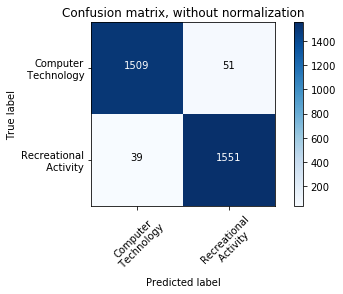

In [30]:
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(lsi_train, lsi_test, binary_train_target, binary_test_target
                                ,C=1000)
fprs.append(fpr)
tprs.append(tpr)

SVM using LSI
gamma: auto
Accuracy: 0.504761904762
Precision: 0.504761904762
Recall: 1.0
F-1 Score: 0.670886075949
Confusion matrix, without normalization
[[   0 1560]
 [   0 1590]]


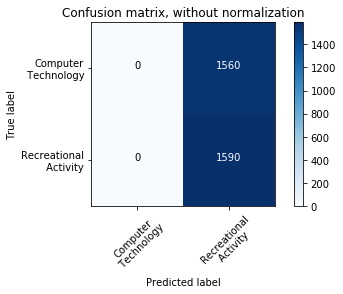

In [31]:
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(lsi_train, lsi_test, binary_train_target, binary_test_target
                                ,C=0.0001)
fprs.append(fpr)
tprs.append(tpr)

SVM using NMF
gamma: auto
Accuracy: 0.966349206349
Precision: 0.958590852905
Recall: 0.975471698113
F-1 Score: 0.966957605985
Confusion matrix, without normalization
[[1493   67]
 [  39 1551]]


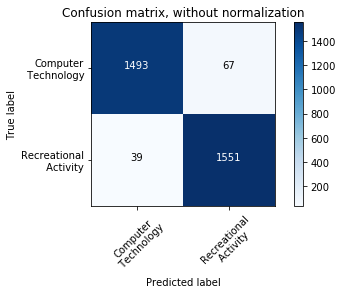

In [32]:
print('SVM using NMF')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target
                                ,C=1000)
fprs.append(fpr)
tprs.append(tpr)

SVM using NMF
gamma: auto
Accuracy: 0.504761904762
Precision: 0.504761904762
Recall: 1.0
F-1 Score: 0.670886075949
Confusion matrix, without normalization
[[   0 1560]
 [   0 1590]]


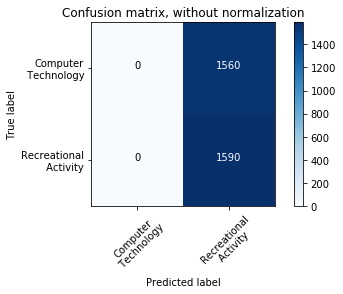

In [33]:
print('SVM using NMF')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target
                                ,C=0.0001)
fprs.append(fpr)
tprs.append(tpr)

In [35]:
# combined_roc_plotter(fprs, tprs, gammas=[1000, 0.001, 1000, 0.001], meths=['LSI', 'LSI', 'NMF', 'NMF'] )

# Optimize using 5-fold Validation for LSI

In [36]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
svm_cv = svm.SVC(probability = True)
svm_cv_grid = GridSearchCV(svm_cv, parameters, cv=5)
svm_cv_grid.fit(lsi_train, binary_train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
pd.DataFrame(svm_cv_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.504861
2,0.1,0.504861
3,1,0.930262
4,10,0.956889
5,100,0.964286
6,1000,0.969146


Based on 5-Fold cross validation, gamma=10 appears to be the best choice for LSI training set.

# Optimize using 5-fold Validation for NWF

In [38]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
svm_cvv = svm.SVC(probability = True)
svm_cvv_grid = GridSearchCV(svm_cvv, parameters, cv=5)
svm_cvv_grid.fit(nmf_train, binary_train_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
pd.DataFrame(svm_cv_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.504861
2,0.1,0.504861
3,1,0.930262
4,10,0.956889
5,100,0.964286
6,1000,0.969146


# Based on 5-Fold cross validation, C=1000 appears to be the best choice for NMF training set.

SVM using LSI
gamma: 10
Accuracy: 0.951111111111
Precision: 0.933051869723
Recall: 0.972955974843
F-1 Score: 0.952586206897
Confusion matrix, without normalization
[[1449  111]
 [  43 1547]]


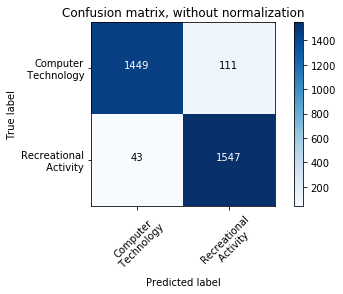

In [32]:
# Training an SVM with this optimized gamma parameter
#begin on this cell
print('SVM using LSI')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target
                                ,C=1000)
fprs.append(fpr)
tprs.append(tpr)


SVM using NMF
gamma: 10
Accuracy: 0.951111111111
Precision: 0.933051869723
Recall: 0.972955974843
F-1 Score: 0.952586206897
Confusion matrix, without normalization
[[1449  111]
 [  43 1547]]


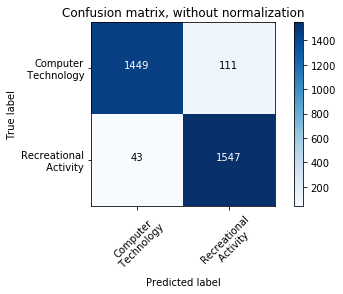

In [33]:
# Training an SVM with this optimized gamma parameter
print('SVM using NMF')
fpr,tpr = predict_calculate_svc(nmf_train, nmf_test, binary_train_target, binary_test_target
                                ,gamma=1000)
fprs.append(fpr)
tprs.append(tpr)


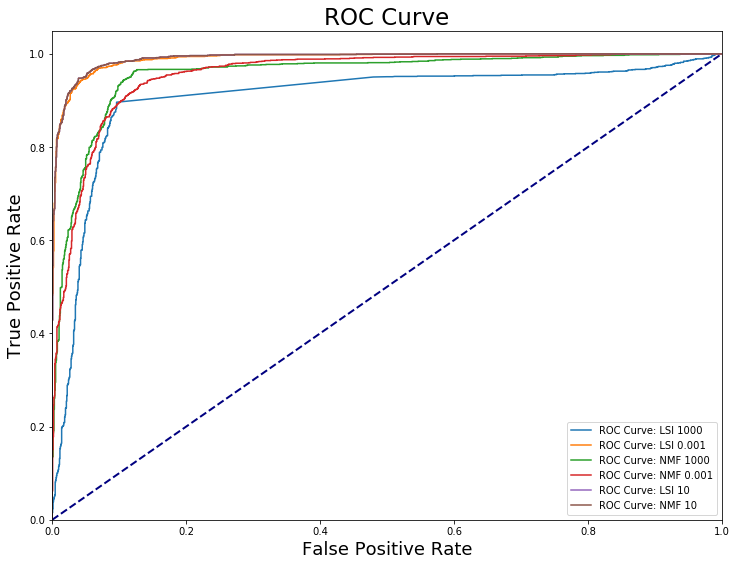

In [34]:
combined_roc_plotter(fprs, tprs, gammas=[1000, 0.001, 1000, 0.001, 1000,1000], meths=['LSI', 'LSI', 'NMF', 'NMF', 'LSI','NMF'] )

In [35]:
### QUESTION 5: Logistic classifier:
### • Train a logistic classifier; plot the ROC curve and report the confusion matrix
### and calculate the accuracy, recall precision and F-1 score of this classifier.
### • Regularization:
### – Using 5-fold cross-validation, find the best regularization strength in the
### range f10kj􀀀3  k  3; k 2 Zg for logistic regression with L1 regularization
### and logistic regression L2 regularization, respectively.
### – Compare the performance (accuracy, precision, recall and F-1 score) of
### 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2
### regularization, using test data. How does the regularization parameter
### affect the test error? How are the learnt coefficients affected? Why
### might one be interested in each type of regularization?

# Logistic Regression Without Regularization (Very High C-value) using LSI

In [40]:
fprs = []
tprs = []

# Logistic Regression using LSI With L1 Regularization

In [41]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l1 = LogisticRegression(penalty="l1")
logistic_l1_grid = GridSearchCV(logistic_l1, parameters,cv=5) #use logistic regression's default score()?
logistic_l1_grid.fit(lsi_train, binary_train_target)

pd.DataFrame(logistic_l1_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.919062
2,0.1,0.927303
3,1,0.964708
4,10,0.970626
5,100,0.969780
6,1000,0.969569


# Logistic Regression using LSI With L2 Regularization

In [42]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l2 = LogisticRegression(penalty="l2")
logistic_l2_grid = GridSearchCV(logistic_l2, parameters,cv=5) #use logistic regression's default score()?
logistic_l2_grid.fit(lsi_train, binary_train_target)

pd.DataFrame(logistic_l2_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.762468
1,0.01,0.926669
2,0.1,0.948859
3,1,0.957523
4,10,0.967033
5,100,0.971682
6,1000,0.969992


Logistic Regression with LSI (without regularization)
C value: 1000000000000000
Penalty: l2
Accuracy: 0.970793650794
Precision: 0.968125
Recall: 0.974213836478
F-1 Score: 0.971159874608
Coefficient Statistics: 
mean = 1.143427, std = 23.095326
Confusion matrix, without normalization
[[1509   51]
 [  41 1549]]


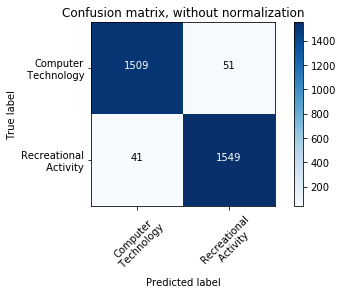

In [43]:
print('Logistic Regression with LSI (without regularization)')
fpr,tpr = predict_calculate_logistics(lsi_train, lsi_test, binary_train_target, binary_test_target,
                                      c_value=10**15)
fprs.append(fpr)
tprs.append(tpr)

# Logistic Regression Analysis with LSI

Based on the cross-validation above, it seems that a C=10^3 leads to the highest validation mean accuracy. Thus, C = 1000 will be used in testing logistic regression classifiers in both L1 and L2 regularization methods.

Logistic Regression with LSI
C value: 100
Penalty: l1
Accuracy: 0.970476190476
Precision: 0.967520299813
Recall: 0.974213836478
F-1 Score: 0.970855531181
Coefficient Statistics: 
mean = 1.174391, std = 22.378783
Confusion matrix, without normalization
[[1508   52]
 [  41 1549]]


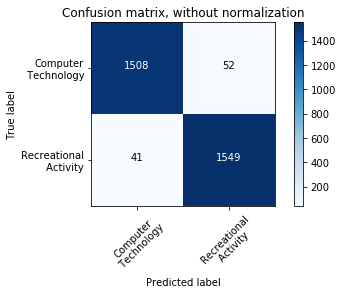

In [44]:
print('Logistic Regression with LSI')
fpr,tpr = predict_calculate_logistics(lsi_train, lsi_test, binary_train_target, binary_test_target,
                                      c_value=10**2, penalty='l1')
fprs.append(fpr)
tprs.append(tpr)

Logistic Regression with LSI
C value: 1000
Penalty: l2
Accuracy: 0.970476190476
Precision: 0.966936993138
Recall: 0.974842767296
F-1 Score: 0.970873786408
Coefficient Statistics: 
mean = 1.182240, std = 21.206488
Confusion matrix, without normalization
[[1507   53]
 [  40 1550]]


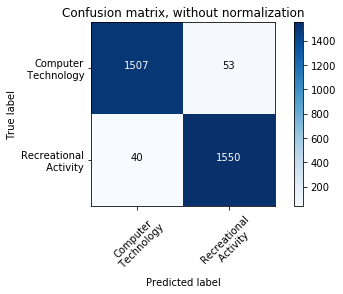

In [45]:
print('Logistic Regression with LSI')
fpr,tpr = predict_calculate_logistics(lsi_train, lsi_test, binary_train_target, binary_test_target,
                                      c_value=10**3, penalty='l2')
fprs.append(fpr)
tprs.append(tpr)

# Logistic Regression Without Regularization (Very High C-value) using NMF

# Logistic Regression using NMF With L1 Regularization

In [46]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l1 = LogisticRegression(penalty="l1")
logistic_l1_grid = GridSearchCV(logistic_l1, parameters,cv=5) #use logistic regression's default score()?
logistic_l1_grid.fit(nmf_train, binary_train_target)

pd.DataFrame(logistic_l1_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.495139
2,0.1,0.645604
3,1,0.950549
4,10,0.963652
5,100,0.961327
6,1000,0.961327


# Logistic Regression using NMF With L2 Regularization

In [47]:
parameters = {'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}
logistic_l2 = LogisticRegression(penalty="l2")
logistic_l2_grid = GridSearchCV(logistic_l2, parameters,cv=5) #use logistic regression's default score()?
logistic_l2_grid.fit(nmf_train, binary_train_target)

pd.DataFrame(logistic_l2_grid.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.560440
2,0.1,0.895604
3,1,0.927303
4,10,0.943998
5,100,0.954565
6,1000,0.961750


# Logistic Regression Analysis with NMF

Based on the cross-validation above, it seems that a C=10 leads to the highest validation mean accuracy for L1, and C=1000 leads to the highest validation mean accuracy for L2 regularization. Thus, C=10 will be used for L1 regularziation and C=1000 will be used for L2 regularization.

Logistic Regression with MWF (without regularization)
C value: 1000000000000000
Penalty: l2
Accuracy: 0.967301587302
Precision: 0.959802102659
Recall: 0.976100628931
F-1 Score: 0.96788275647
Coefficient Statistics: 
mean = -10.083805, std = 108.359955
Confusion matrix, without normalization
[[1495   65]
 [  38 1552]]


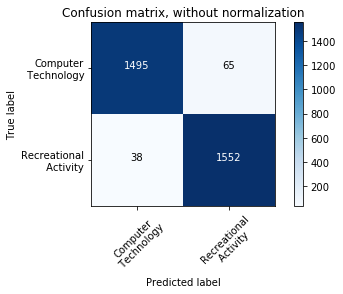

In [48]:
print('Logistic Regression with MWF (without regularization)')
fpr,tpr = predict_calculate_logistics(nmf_train, nmf_test, binary_train_target, binary_test_target,
                                      c_value=10**15)
fprs.append(fpr)
tprs.append(tpr)

Logistic Regression with MWF
C value: 100
Penalty: l1
Accuracy: 0.966984126984
Precision: 0.959208899876
Recall: 0.976100628931
F-1 Score: 0.967581047382
Coefficient Statistics: 
mean = -8.200970, std = 93.483913
Confusion matrix, without normalization
[[1494   66]
 [  38 1552]]


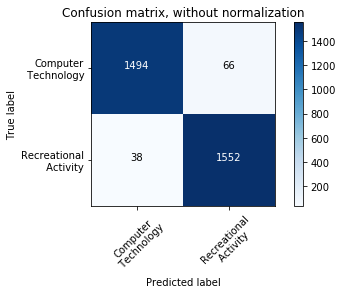

In [49]:
print('Logistic Regression with MWF')
fpr,tpr = predict_calculate_logistics(nmf_train, nmf_test, binary_train_target, binary_test_target,
                                      c_value=10**2,penalty='l1')
fprs.append(fpr)
tprs.append(tpr)

Logistic Regression with MWF
C value: 1000
Penalty: l2
Accuracy: 0.962222222222
Precision: 0.953732264035
Recall: 0.972327044025
F-1 Score: 0.962939894114
Coefficient Statistics: 
mean = -6.791923, std = 54.822824
Confusion matrix, without normalization
[[1485   75]
 [  44 1546]]


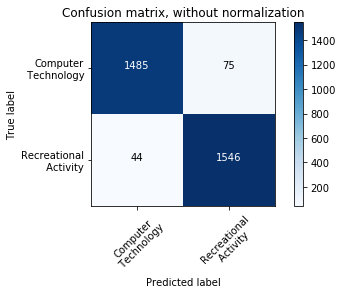

In [50]:
print('Logistic Regression with MWF')
fpr,tpr = predict_calculate_logistics(nmf_train, nmf_test, binary_train_target, binary_test_target,
                                      c_value=10**3,penalty='l2')
fprs.append(fpr)
tprs.append(tpr)

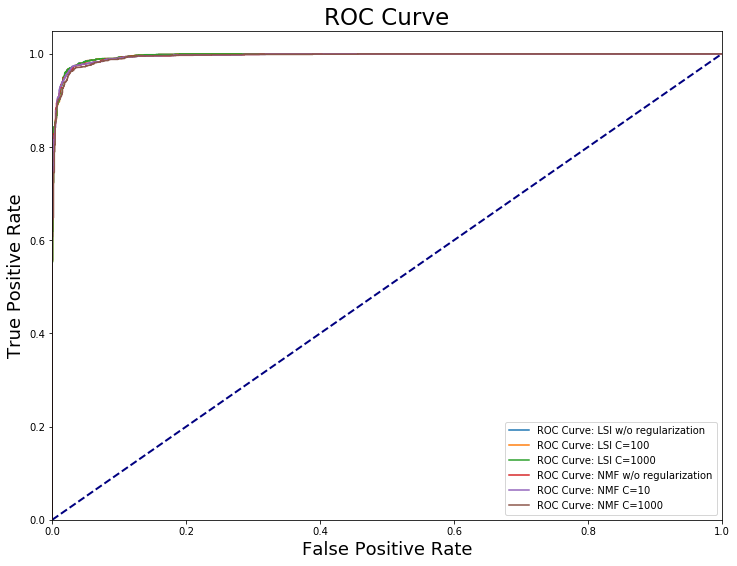

In [51]:
combined_roc_plotter(fprs, tprs, gammas=['w/o regularization', 'C=100','C=1000','w/o regularization','C=10','C=1000'],
                     meths=['LSI','LSI','LSI','NMF','NMF','NMF'] )

# Naive Bayes Classifier

In [52]:
### QUESTION 6: Naïve Bayes classifier: train a GaussianNB classifier; plot the ROC
### curve and report the confusion matrix and calculate the accuracy, recall precision
### and F-1 score of this classifier.

In [53]:
fprs = []
tprs = []

Naive Bayes using LSI
Accuracy: 0.8
Precision: 0.725352112676
Recall: 0.971698113208
F-1 Score: 0.83064516129
Confusion matrix, without normalization
[[ 975  585]
 [  45 1545]]


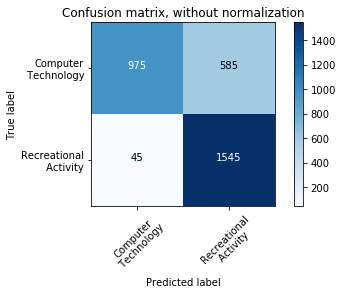

In [54]:
print('Naive Bayes using LSI')
fpr,tpr = predict_calculate_naive_bayes(lsi_train, lsi_test, binary_train_target, binary_test_target)
fprs.append(fpr)
tprs.append(tpr)

Naive Bayes using NMF
Accuracy: 0.941587301587
Precision: 0.914016489988
Recall: 0.976100628931
F-1 Score: 0.94403892944
Confusion matrix, without normalization
[[1414  146]
 [  38 1552]]


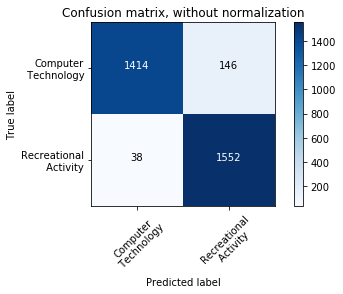

In [55]:
print('Naive Bayes using NMF')
fpr,tpr = predict_calculate_naive_bayes(nmf_train, nmf_test, binary_train_target, binary_test_target)
fprs.append(fpr)
tprs.append(tpr)

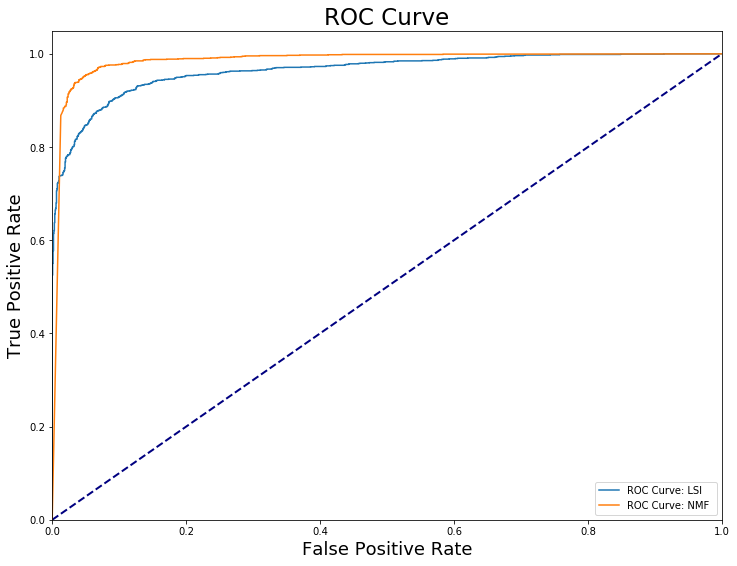

In [56]:
combined_roc_plotter(fprs, tprs, gammas=['', ''], meths=['LSI', 'NMF'] )

# Grid Search of Parameters

In [57]:
### QUESTION 7: Grid search of parameters:
### • Construct a Pipeline that performs feature extraction, dimensionality reduction
### and classification;
### • Do grid search with 5-fold cross-validation to compare the following (use test
### accuracy as the score to compare):

In [45]:
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

print("Cell started")
start = time.time()

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

print("Building Pipeline")
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50,random_state=0)),
    ('clf', GaussianNB()),
])

BEST_GAMMA_SVM = 1000
BEST_C_LOGISTIC_REG = 1000
MIN_DF_OPTIONS = [3,5]
LOGISTIC_REG_PENALTY = ['l1','l2']

param_grid = [
     {
         'vect__min_df': [3, 5],
         'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
         'clf': [SVC(C=BEST_GAMMA_SVM),GaussianNB()]
     },
     {
         'vect__min_df': [3, 5],
         'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
         'clf': [LogisticRegression(C=BEST_C_LOGISTIC_REG)],
         'clf__penalty': LOGISTIC_REG_PENALTY
     }
]
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid2 = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid3 = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid4 = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')

# Generate targets with REMOVED headers and footers
train_rmv_headfoot_target = [0 if t<4 else 1 for t in train_dataset_rmv_headfoot.target]
test_lemm_rmv_headfoot_target = [0 if t<4 else 1 for t in test_dataset_rmv_headfoot.target]
# Generate targets with KEPT headers and footers
train_dataset_keep_headfoot_target = [0 if t<4 else 1 for t in train_dataset_keep_headfoot.target]
test_dataset_keep_headfoot_target = [0 if t<4 else 1 for t in test_dataset_keep_headfoot.target]

# Load lemmitized data
trainLemmRmv = pickle.load(open("train_lem_rmv.pkl","rb"))
testLemmRmv = pickle.load(open("test_lem_rmv.pkl","rb"))
trainLemmKeep = pickle.load(open("train_lem_keep.pkl","rb"))
testLemmRmv = pickle.load(open("test_lem_keep.pkl","rb"))

# Fit REMOVED HEADERS AND FOOTERS, LEMMITIZED
print("Fitting grid 1...")
t1 = time.time()
grid1.fit(trainLemmRmv, train_rmv_headfoot_target)
print("Fit grid 1 in %f sec" % (time.time()-t1))

print("Fitting grid 2...")
t1 = time.time()
# Fit REMOVED HEADERS AND FOOTERS, NOT LEMMITIZED
grid2.fit(train_dataset_rmv_headfoot.data, train_rmv_headfoot_target)
print("Fit grid 2 in %f sec" % (time.time()-t1))

print("Fitting grid 3...")
t1 = time.time()
# Fit KEPT HEADERS AND FOOTERS, LEMMITIZED
grid3.fit(trainLemmKeep, train_dataset_keep_headfoot_target)
print("Fit grid 3 in %f sec" % (time.time()-t1))

print("Fitting grid 4...")
t1 = time.time()
# Fit KEPT HEADERS AND FOOTERS, NOT LEMMITIZED
grid4.fit(train_dataset_keep_headfoot.data, train_dataset_keep_headfoot_target)
print("Fit grid 4 in %f sec" % (time.time()-t1))

pickle.dump( grid1, open("grid1.pkl","wb"))
pickle.dump( grid2, open("grid2.pkl","wb"))
pickle.dump( grid3, open("grid3.pkl","wb"))
pickle.dump( grid4, open("grid4.pkl","wb"))

rmtree(cachedir)

end = time.time()
print(end - start)

Cell started
Building Pipeline
Fitting grid 1...
Fit grid 1 in 958.492435 sec
Fitting grid 2...
Fit grid 2 in 1033.402858 sec
Fitting grid 3...
Fit grid 3 in 1031.397485 sec
Fitting grid 4...
Fit grid 4 in 1161.263717 sec
4187.913783073425


In [33]:
# Generate targets with REMOVED headers and footers
train_rmv_headfoot_target = [0 if t<4 else 1 for t in train_dataset_rmv_headfoot.target]
test_lemm_rmv_headfoot_target = [0 if t<4 else 1 for t in test_dataset_rmv_headfoot.target]
# Generate targets with KEPT headers and footers
train_dataset_keep_headfoot_target = [0 if t<4 else 1 for t in train_dataset_keep_headfoot.target]
test_dataset_keep_headfoot_target = [0 if t<4 else 1 for t in test_dataset_keep_headfoot.target]

len(train_rmv_headfoot_target)


4732

In [73]:
frame1 = pd.DataFrame(grid1.cv_results_)
frame1["lemm"]=True
frame1["rmv_"] = True

frame2 = pd.DataFrame(grid2.cv_results_)
frame2["lemm"]=False
frame2["rmv_headfoot"] = True

frame3 = pd.DataFrame(grid3.cv_results_)
frame3["lemm"]=True
frame3["rmv_headfoot"] = False

frame4 = pd.DataFrame(grid4.cv_results_)
frame4["lemm"]=False
frame4["rmv_headfoot"] = False

frames = [frame1,frame2,frame3,frame4]
results = pd.concat(frames)

# Show sample results
results = results.sort_values(by=['mean_test_score'],ascending=False)
results = results.reset_index(drop=True)
results[['mean_test_score', 'param_clf', 'param_clf__penalty','param_reduce_dim','param_vect__min_df',"lemm","rmv_headfoot"]].head()

,mean_test_score,param_clf,param_clf__penalty,param_reduce_dim,param_vect__min_df,lemm,rmv_headfoot
0,0.976543,"LogisticRegression(C=1000, class_weight=None, ...",l2,"TruncatedSVD(algorithm='randomized', n_compone...",3,False,False
1,0.975697,"LogisticRegression(C=1000, class_weight=None, ...",l1,"TruncatedSVD(algorithm='randomized', n_compone...",3,True,False
2,0.975275,"LogisticRegression(C=1000, class_weight=None, ...",l1,"TruncatedSVD(algorithm='randomized', n_compone...",3,False,False
3,0.975063,"LogisticRegression(C=1000, class_weight=None, ...",l2,"TruncatedSVD(algorithm='randomized', n_compone...",3,True,False
4,0.975063,"SVC(C=1000, cache_size=200, class_weight=None,...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",3,False,False


# Multiclass Classification

In [58]:
### QUESTION 8: In this part, we aim to learn classifiers on the documents belonging
### to the classes:
### comp.sys.ibm.pc.hardware, comp.sys.mac.hardware,
### misc.forsale, soc.religion.christian
### Perform Naïve Bayes classification and multiclass SVM classification (with both
### One VS One and One VS the rest methods described above) and report the confusion
### matrix and calculate the accuracy, recall, precision and F-1 score of
### your classifiers.

In [59]:
# 1. get categories
multi_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
# 2. clean dataset, tokenize, remove stop words and punctuation, and stem
multi_data = fetch_20newsgroups(subset='train', categories=multi_categories, shuffle=True, random_state=42)
multi_data_test = fetch_20newsgroups(subset='test', categories=multi_categories, shuffle=True, random_state=42)

In [60]:
multi_data.target.shape

(2352,)

In [63]:
multi_data.target_names = multi_data.target_names + ['','','','']

In [64]:
multi_data_test.target_names = multi_data_test.target_names +['','','','']

Length: 2352


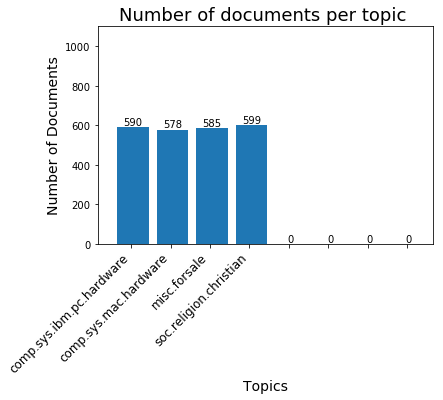

Length: 1565


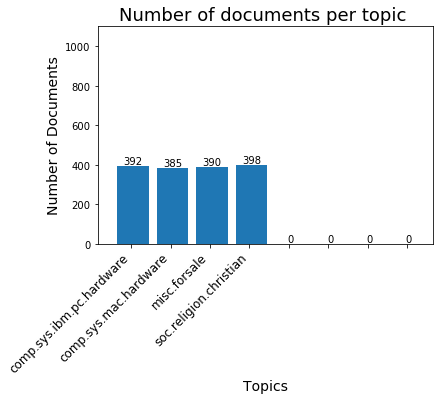

In [66]:
# plot histogram to view data distribution
plot_histogram(multi_data.target, multi_data.target_names)
plot_histogram(multi_data_test.target, multi_data_test.target_names)

In [61]:
# down sample majority data using random to have same number of samples as minority
print("since dataset evenly distributed, no downsampling needed.")

since dataset evenly distributed, no downsampling needed.


In [62]:
train_dataset_lemmatized = []
test_dataset_lemmatized = []
lemma_data = [train_dataset_lemmatized, test_dataset_lemmatized]
lemma_data_multi = [multi_data, multi_data_test]

for idx, d in enumerate(lemma_data_multi):
    for item in d.data:
        lemma_data[idx].append(' '.join(lemmatize_parse(item)))
    
multi_data.data = train_dataset_lemmatized
multi_data_test.data = test_dataset_lemmatized

In [ ]:
# vectorize data
multi_data_cleaned = vectorizer.fit_transform(multi_data.data)
multi_data_test_cleaned = vectorizer.transform(multi_data_test.data)

In [ ]:
tfidf_transformer = TfidfTransformer()

In [48]:
multiclass_data = multi_data_cleaned
multiclass_data_test = multi_data_test_cleaned
# transform data for TFIDF, LSI, NMF comparison
tfidf_multi = tfidf_transformer.fit_transform(multiclass_data).toarray()
lsi_multi = lsi.fit_transform(multiclass_data)
nmf_multi = nmf.fit_transform(multiclass_data)

tfidf_multi_test = tfidf_transformer.transform(multiclass_data_test).toarray()
lsi_multi_test = lsi.transform(multiclass_data_test)
nmf_multi_test = nmf.transform(multiclass_data_test)

In [49]:
X_multi = [tfidf_multi, lsi_multi, nmf_multi]
y_multi = multi_data.target
X_multi_test = [tfidf_multi_test, lsi_multi_test, nmf_multi_test]
y_multi_test = multi_data_test.target

In [ ]:
#==== Do not need to scale with GaussianNB======
#scaler = MinMaxScaler()
#lsi_multi_scaled = scaler.fit_transform(lsi_multi)
#lsi_multi_test_scaled = scaler.transform(lsi_multi_test)
#lsi_scaled = [lsi_multi_scaled, lsi_multi_test_scaled]

In [51]:
# Naive Bayes
multiclass_NB = GaussianNB()
labels = ['TFIDF', 'LSI', 'NMF'] # LSI, NMF
for idx, x in enumerate(X_multi):
    if (idx < len(labels)):
        #if (labels[idx] == 'N/A'):
            #multiclass_NB.fit(lsi_scaled[0], y_multi)
            #multiclass_NB_pred = multiclass_NB.predict(lsi_scaled[1])
        #else:
            # train model
        multiclass_NB.fit(x, y_multi)
            # get test results
        multiclass_NB_pred = multiclass_NB.predict(X_multi_test[idx])
        multiclass_NB_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_NB_pred)
        multiclass_NB_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_NB_pred)
        multiclass_NB_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        multiclass_NB_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        multiclass_NB_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_NB_confusion)
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Accuracy Score: " + str(multiclass_NB_accuracy))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Recall Score: " + str(multiclass_NB_recall))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Precision Score: " + str(multiclass_NB_precision))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " f1 Score: " + str(multiclass_NB_f1))

Multiclass NaiveBayes TFIDF Confusion matrix: 
[[351  24  17   0]
 [ 34 334  17   0]
 [ 32  11 346   1]
 [  7   1   1 389]]
Multiclass NaiveBayes TFIDF Accuracy Score: 0.907348242812
Multiclass NaiveBayes TFIDF Recall Score: 0.907348242812
Multiclass NaiveBayes TFIDF Precision Score: 0.907348242812
Multiclass NaiveBayes TFIDF f1 Score: 0.907348242812
Multiclass NaiveBayes LSI Confusion matrix: 
[[ 70   0   0 322]
 [ 11   1   0 373]
 [ 14   0   3 373]
 [  1   0   0 397]]
Multiclass NaiveBayes LSI Accuracy Score: 0.300958466454
Multiclass NaiveBayes LSI Recall Score: 0.300958466454
Multiclass NaiveBayes LSI Precision Score: 0.300958466454
Multiclass NaiveBayes LSI f1 Score: 0.300958466454
Multiclass NaiveBayes NMF Confusion matrix: 
[[292  45  54   1]
 [ 77 259  47   2]
 [ 54  22 305   9]
 [  8   1  15 374]]
Multiclass NaiveBayes NMF Accuracy Score: 0.785942492013
Multiclass NaiveBayes NMF Recall Score: 0.785942492013
Multiclass NaiveBayes NMF Precision Score: 0.785942492013
Multiclass N

In [59]:
# Multiclass SVM classification
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
multiclass_svm_OvO = OneVsOneClassifier(SVC())
multiclass_svm_OvR = OneVsRestClassifier(SVC())

In [60]:
labels = ['TFIDF', 'LSI', 'NMF'] #, 'LSI', 'NMF'
for idx, x in enumerate(X_multi):
    if (idx < len(labels)):
        # train model
        multiclass_svm_OvO.fit(x, y_multi)
        # get test results
        multiclass_svm_OvO_pred = multiclass_svm_OvO.predict(X_multi_test[idx])
        multiclass_svm_OvO_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred)
        multiclass_svm_OvO_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred)
        multiclass_svm_OvO_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        multiclass_svm_OvO_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        multiclass_svm_OvO_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        print("Multiclass SVM OvO " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_svm_OvO_confusion)
        print("Multiclass SVM OvO " + labels[idx] + " Accuracy Score: " + str(multiclass_svm_OvO_accuracy))
        print("Multiclass SVM OvO " + labels[idx] + " Recall Score: " + str(multiclass_svm_OvO_recall))
        print("Multiclass SVM OvO " + labels[idx] + " Precision Score: " + str(multiclass_svm_OvO_precision))
        print("Multiclass SVM OvO " + labels[idx] + " f1 Score: " + str(multiclass_svm_OvO_f1))

Multiclass SVM OvO TFIDF Confusion matrix: 
[[  0   0   0 392]
 [  0   0   0 385]
 [  0   0   0 390]
 [  0   0   0 398]]
Multiclass SVM OvO TFIDF Accuracy Score: 0.254313099042
Multiclass SVM OvO TFIDF Recall Score: 0.254313099042
Multiclass SVM OvO TFIDF Precision Score: 0.254313099042
Multiclass SVM OvO TFIDF f1 Score: 0.254313099042
Multiclass SVM OvO LSI Confusion matrix: 
[[312  45  26   9]
 [ 64 294  20   7]
 [ 30  21 325  14]
 [  7   1   4 386]]
Multiclass SVM OvO LSI Accuracy Score: 0.841533546326
Multiclass SVM OvO LSI Recall Score: 0.841533546326
Multiclass SVM OvO LSI Precision Score: 0.841533546326
Multiclass SVM OvO LSI f1 Score: 0.841533546326
Multiclass SVM OvO NMF Confusion matrix: 
[[143   0 249   0]
 [ 33  28 323   1]
 [ 18   0 372   0]
 [  1   0 234 163]]
Multiclass SVM OvO NMF Accuracy Score: 0.451118210863
Multiclass SVM OvO NMF Recall Score: 0.451118210863
Multiclass SVM OvO NMF Precision Score: 0.451118210863
Multiclass SVM OvO NMF f1 Score: 0.451118210863


In [61]:
labels = ['TFIDF', 'LSI', 'NMF'] # , 'LSI', 'NMF'
for idx, x in enumerate(X_multi):
    if (idx < len(labels)):
        # train model
        multiclass_svm_OvR.fit(x, y_multi)
        # get test results
        multiclass_svm_OvR_pred = multiclass_svm_OvR.predict(X_multi_test[idx])
        multiclass_svm_OvR_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred)
        multiclass_svm_OvR_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred)
        multiclass_svm_OvR_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        multiclass_svm_OvR_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        multiclass_svm_OvR_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        print("Multiclass SVM OvR " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_svm_OvR_confusion)
        print("Multiclass SVM OvR " + labels[idx] + " Accuracy Score: " + str(multiclass_svm_OvR_accuracy))
        print("Multiclass SVM OvR " + labels[idx] + " Recall Score: " + str(multiclass_svm_OvR_recall))
        print("Multiclass SVM OvR " + labels[idx] + " Precision Score: " + str(multiclass_svm_OvR_precision))
        print("Multiclass SVM OvR " + labels[idx] + " f1 Score: " + str(multiclass_svm_OvR_f1))

Multiclass SVM OvR TFIDF Confusion matrix: 
[[312  23  29  28]
 [ 27 297  24  37]
 [ 13   7 355  15]
 [  0   0   0 398]]
Multiclass SVM OvR TFIDF Accuracy Score: 0.870287539936
Multiclass SVM OvR TFIDF Recall Score: 0.870287539936
Multiclass SVM OvR TFIDF Precision Score: 0.870287539936
Multiclass SVM OvR TFIDF f1 Score: 0.870287539936
Multiclass SVM OvR LSI Confusion matrix: 
[[304  47  31  10]
 [ 46 303  23  13]
 [ 19  20 336  15]
 [  2   0   3 393]]
Multiclass SVM OvR LSI Accuracy Score: 0.853674121406
Multiclass SVM OvR LSI Recall Score: 0.853674121406
Multiclass SVM OvR LSI Precision Score: 0.853674121406
Multiclass SVM OvR LSI f1 Score: 0.853674121406
Multiclass SVM OvR NMF Confusion matrix: 
[[251  66  36  39]
 [ 41 275  27  42]
 [ 30  17 324  19]
 [  1   0   5 392]]
Multiclass SVM OvR NMF Accuracy Score: 0.793610223642
Multiclass SVM OvR NMF Recall Score: 0.793610223642
Multiclass SVM OvR NMF Precision Score: 0.793610223642
Multiclass SVM OvR NMF f1 Score: 0.793610223642
